#ATUS Analysis
This notebook documents an initial exploration of the dataset provided by the [American Time Use Survey](http://www.bls.gov/tus/)

####* [Jump to Table of Contents](#Table-of-Contents:)

In [1]:
import pandas as pd
import numpy as np
import math
import re
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import atus  # Custom atus helper and analysis functions
import parse_activities as pa # Contains lookup dictionaries/lists for activity codes generated from PDF scrape
%matplotlib inline

In [2]:
!ls atusdata/  # These datafiles were downloaded via the download_data script

activity_codes.pdf  atusact_2013.zip    atuscps_2013.zip    atusresp_2013.zip   atusrost_2013.zip   atusrostec_2013.zip atussum_2013.zip    atususersguide.pdf  atuswho_2013.zip    data_dictionary.pdf


##Relevant links:
These files provide detailed supporting information on the dataset files
- [activity_codes.pdf](atusdata/activity_codes.pdf)

- [atususersguide.pdf](atusdata/atususersguide.pdf)

- [data_dictionary.pdf](atusdata/data_dictionary.pdf)

In [3]:
# Open the summary file
summary = atus.open_zip('atussum_2013')
summary.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [5]:
# Clean up the demographic column titles to be more readable
variables = sorted(list(summary.columns.values)[:24])
meanings =  ['metropolitan_status',
             'education_level',
             'is_hispanic',
             'race',
             'age_edited',
             'weekly_hours_worked',
             'employment_status',
             'has_multiple_jobs',
             'is_student',
             'school_level',
             'gender',
             'partner_employed',
             'household_children',
             'work_status',
             'weekly_earnings_main',
             'is_holiday',
             'partner_work_status',
             'partner_present',
             'eldercare_minutes',
             'childcare_minutes',
             'youngest_child_age',
             'date',
             'atus_final_weight',
             'atus_case_id']

summary_columns = {key: meanings[i] for i, key in enumerate(variables)}
meanings_unsorted = [summary_columns[key] for key in summary.columns.values[:24]]
# meanings_unsorted.extend(summary.columns.values[24:])
summary_columns

{'GTMETSTA': 'metropolitan_status',
 'PEEDUCA': 'education_level',
 'PEHSPNON': 'is_hispanic',
 'PTDTRACE': 'race',
 'TEAGE': 'age_edited',
 'TEHRUSLT': 'weekly_hours_worked',
 'TELFS': 'employment_status',
 'TEMJOT': 'has_multiple_jobs',
 'TESCHENR': 'is_student',
 'TESCHLVL': 'school_level',
 'TESEX': 'gender',
 'TESPEMPNOT': 'partner_employed',
 'TRCHILDNUM': 'household_children',
 'TRDPFTPT': 'work_status',
 'TRERNWA': 'weekly_earnings_main',
 'TRHOLIDAY': 'is_holiday',
 'TRSPFTPT': 'partner_work_status',
 'TRSPPRES': 'partner_present',
 'TRTEC': 'eldercare_minutes',
 'TRTHH': 'childcare_minutes',
 'TRYHHCHILD': 'youngest_child_age',
 'TUDIARYDAY': 'date',
 'TUFINLWGT': 'atus_final_weight',
 'tucaseid': 'atus_case_id'}

Pertinent columns:

* TUFINLWGT - statistical weight of respondent
* TRYHHCHILD - age of youngest child in household
* TEAGE - age of respondent
* TESEX - sex of respondent
* TELFS - working status of respondent
* TRCHILDNUM - number of children in household

In [6]:
summary.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Get an English version of all the column headings

#import importlib
#importlib.reload(pa)
#del pa
pa.atus_codes_list
pa.codes_dict
z = summary_columns.copy()
z.update(pa.codes_dict)
summary_columns = z
summary_columns
code_meanings = [ pa.codes_dict[i] for i in summary.columns.values[24:]]
meanings_unsorted.extend(code_meanings)
#meanings_unsorted
# summary4 = summary.rename(columns=pa.codes_dict)
# summary4.head()
# summary5 = summary4
# summary5.columns = pd.MultiIndex.from_tuples(list(zip(meanings_unsorted, summary.columns)))
# summary5.head() # .columns.values

In [8]:
# summary3 has a MultiIndex which has the code on the top level and the English meaning on the second level
# this does make indexing it a bit trickier, so we will continue to use summary as well
summary2 = summary.rename(columns=summary_columns)
summary3 = summary2
summary3.columns = pd.MultiIndex.from_tuples(list(zip(summary.columns, meanings_unsorted)))
summary3.head() # .columns.values

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
,atus_case_id,atus_final_weight,youngest_child_age,age_edited,gender,education_level,race,is_hispanic,metropolitan_status,employment_status,...,Travel related to volunteering,"Travel related to volunteer activities, n.e.c.*",Travel related to phone calls,Security procedures related to traveling,"Traveling, n.e.c.*",Insufficient detail in verbatim,Missing travel or destination,"Respondent refused to provide information/""none of your business""",Gap/can't remember,Unable to code activity at 1st tier
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


###An initial calculation

In [9]:
adults_crit = summary.TEAGE >= 18
no_children_crit = summary.TRCHILDNUM == 0



In [10]:
adults = summary[adults_crit]
adults_with_no_children = summary[adults_crit & no_children_crit]

[len(group) for group in [adults, adults_with_no_children]]

[10953, 6481]

In [11]:
# Look at average weighted daily sleep for adults_with_no_children using 3 different methods
# Method 1/3 -- Gets weighted average of a single activity:
data = adults_with_no_children[['TUFINLWGT', 't010101']]
data.head()
data2, avg = atus.weighted(data, 't010101')
data = data.rename(columns={"TUFINLWGT": "weight", "t010101": "minutes"})

data2.head()
avg

521.0183492943637

In [12]:
# Method 2/3 -- Combine two related activities (note that the first result matches previous method):
sleeping = atus.average_minutes(adults_with_no_children, "010101")
sleepless = atus.average_minutes(adults_with_no_children, "010102")
sleeping, sleepless, (sleeping + sleepless)

(521.0183492943637, 4.0328730764962595, 525.05122237085993)

In [13]:
#Method 3/3 -- Use regular expressions to combine related activities (matches previous result):
atus.activity_columns(summary, '0101')
atus.average_minutes2(adults_with_no_children, "0101")

/Users/jdw/ironyard/sandbox/W4D4/atus-analysis/atus.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['minutes'] = activity_sums


525.05122237086005

###The dictionaries and lists in the pa module help us orient ourselves with the data
####See parse_activities.py for the code to convert a flat list of codes into a hierarchical structure
This process would be much nicer (i.e. unnecessary) if the relevant tables were provided in a non-PDF format!

In [14]:
pa.categories  # Broadest level categories

{'t01': 'Personal Care',
 't02': 'Household Activities',
 't03': 'Caring For & Helping Household (HH) Members',
 't04': 'Caring For & Helping Nonhousehold (NonHH) Members',
 't05': 'Work & Work-Related Activities',
 't06': 'Education',
 't07': 'Consumer Purchases',
 't08': 'Professional & Personal Care Services',
 't09': 'Household Services',
 't10': 'Government Services & Civic Obligations',
 't11': 'Eating and Drinking',
 't12': 'Socializing, Relaxing, and Leisure',
 't13': 'Sports, Exercise, and Recreation',
 't14': 'Religious and Spiritual Activities',
 't15': 'Volunteer Activities',
 't16': 'Telephone Calls',
 't18': 'Traveling',
 't50': 'Data Codes'}

In [15]:
pa.codes_dict['t0101']  # A sub-category (Tier 2 of 3)

'Sleeping'

## Joining files

In [16]:
respondents = atus.open_zip('atusresp_2013')
activities = atus.open_zip('atusact_2013')

In [17]:
respondents.info()
respondents.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 175 entries, TUCASEID to TXTONHH
dtypes: float64(1), int64(172), object(2)
memory usage: 15.3+ MB


,TUCASEID,TULINENO,TUYEAR,TUMONTH,TEABSRSN,TEERN,TEERNH1O,TEERNH2,TEERNHRO,TEERNHRY,...,TXSPEMPNOT,TXSPUHRS,TXTCC,TXTCCTOT,TXTCOC,TXTHH,TXTNOHH,TXTO,TXTOHH,TXTONHH
0,20130101130004,1,2013,1,-1,-1,-1,-1,-1,-1,...,-1,-1,0,0,0,0,0,-1,-1,-1
1,20130101130112,1,2013,1,-1,-1,-1,-1,-1,2,...,0,0,0,0,0,0,-1,0,0,-1
2,20130101130123,1,2013,1,-1,-1,-1,-1,-1,-1,...,0,0,-1,0,0,-1,-1,-1,-1,-1
3,20130101130611,1,2013,1,-1,-1,-1,-1,-1,2,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1
4,20130101130616,1,2013,1,-1,-1,-1,-1,-1,2,...,-1,-1,-1,0,0,-1,-1,-1,-1,-1


In [18]:
activities.info()
activities.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215576 entries, 0 to 215575
Data columns (total 31 columns):
TUCASEID        215576 non-null int64
TUACTIVITY_N    215576 non-null int64
TEWHERE         215576 non-null int64
TRTCCTOT_LN     215576 non-null int64
TRTCC_LN        215576 non-null int64
TRTCOC_LN       215576 non-null int64
TRTEC_LN        215576 non-null int64
TRTHH_LN        215576 non-null int64
TRTNOHH_LN      215576 non-null int64
TRTOHH_LN       215576 non-null int64
TRTONHH_LN      215576 non-null int64
TRTO_LN         215576 non-null int64
TRWBELIG        215576 non-null int64
TUACTDUR        215576 non-null int64
TUACTDUR24      215576 non-null int64
TUCC5           215576 non-null int64
TUCC5B          215576 non-null int64
TUCC7           215576 non-null int64
TUCC8           215576 non-null int64
TUCUMDUR        215576 non-null int64
TUCUMDUR24      215576 non-null int64
TUDURSTOP       215576 non-null int64
TUEC24          215576 non-null int64
TUSTARTTIM     

,TUCASEID,TUACTIVITY_N,TEWHERE,TRTCCTOT_LN,TRTCC_LN,TRTCOC_LN,TRTEC_LN,TRTHH_LN,TRTNOHH_LN,TRTOHH_LN,...,TUDURSTOP,TUEC24,TUSTARTTIM,TUSTOPTIME,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TXWHERE
0,20130101130004,1,-1,0,0,0,-1,0,0,-1,...,2,-1,04:00:00,12:00:00,1,1,1,10101,101,0
1,20130101130004,2,1,5,5,0,-1,5,5,-1,...,1,-1,12:00:00,12:05:00,11,1,1,110101,1101,0
2,20130101130004,3,1,120,120,0,-1,120,120,-1,...,1,-1,12:05:00,14:05:00,12,3,3,120303,1203,0
3,20130101130004,4,1,0,0,0,-1,0,0,-1,...,2,-1,14:05:00,19:00:00,6,3,1,60301,603,0
4,20130101130004,5,1,30,30,0,-1,30,30,-1,...,1,-1,19:00:00,19:30:00,11,1,1,110101,1101,0


In [19]:
merged = pd.merge(respondents, activities, left_on="TUCASEID", right_on="TUCASEID")
merged.info()
merged.head()
# merged[["TUCASEID", "TUACTIVITY_N", "TXTCOC"]].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215576 entries, 0 to 215575
Columns: 205 entries, TUCASEID to TXWHERE
dtypes: float64(1), int64(200), object(4)
memory usage: 338.8+ MB


,TUCASEID,TULINENO,TUYEAR,TUMONTH,TEABSRSN,TEERN,TEERNH1O,TEERNH2,TEERNHRO,TEERNHRY,...,TUDURSTOP,TUEC24,TUSTARTTIM,TUSTOPTIME,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TXWHERE
0,20130101130004,1,2013,1,-1,-1,-1,-1,-1,-1,...,2,-1,04:00:00,12:00:00,1,1,1,10101,101,0
1,20130101130004,1,2013,1,-1,-1,-1,-1,-1,-1,...,1,-1,12:00:00,12:05:00,11,1,1,110101,1101,0
2,20130101130004,1,2013,1,-1,-1,-1,-1,-1,-1,...,1,-1,12:05:00,14:05:00,12,3,3,120303,1203,0
3,20130101130004,1,2013,1,-1,-1,-1,-1,-1,-1,...,2,-1,14:05:00,19:00:00,6,3,1,60301,603,0
4,20130101130004,1,2013,1,-1,-1,-1,-1,-1,-1,...,1,-1,19:00:00,19:30:00,11,1,1,110101,1101,0


In [20]:
telfs = pd.Series({1: "Employed - at work",
                   2: "Employed - absent",
                   3: "Unemployed - laid off",
                   4: "Unemployed - looking",
                   5: "Not in labor force"})
summary.TELFS.map(telfs).head()

0      Not in labor force
1      Employed - at work
2    Unemployed - looking
3      Employed - at work
4      Employed - at work
Name: TELFS, dtype: object

##Correlation matrix

In [21]:
#import numpy as np
df = pd.DataFrame(np.random.random((5, 5)))
corr_series = df.corr().stack()
corr_series[(corr_series.map(math.fabs) >= 0.5) & (corr_series != 1.0)]


0  1   -0.741208
   4   -0.582657
1  0   -0.741208
2  3    0.865824
3  2    0.865824
4  0   -0.582657
dtype: float64

#Verifying summary statistics from BLS website:
###http://www.bls.gov/tus/charts/home.htm

1. Americans >= 15 years old slept 8.7 hours, 
2. spent 5.3 hours doing leisure/sports activities
3. 3.5 hours working
4. 1.8 hours doing household activities.

In [22]:
s = summary3  # The dataframe with meaningful column names
[col for col in s.columns if not col[1].startswith('t')] # the summary demographic information about respondents

[('tucaseid', 'atus_case_id'),
 ('TUFINLWGT', 'atus_final_weight'),
 ('TRYHHCHILD', 'youngest_child_age'),
 ('TEAGE', 'age_edited'),
 ('TESEX', 'gender'),
 ('PEEDUCA', 'education_level'),
 ('PTDTRACE', 'race'),
 ('PEHSPNON', 'is_hispanic'),
 ('GTMETSTA', 'metropolitan_status'),
 ('TELFS', 'employment_status'),
 ('TEMJOT', 'has_multiple_jobs'),
 ('TRDPFTPT', 'work_status'),
 ('TESCHENR', 'is_student'),
 ('TESCHLVL', 'school_level'),
 ('TRSPPRES', 'partner_present'),
 ('TESPEMPNOT', 'partner_employed'),
 ('TRERNWA', 'weekly_earnings_main'),
 ('TRCHILDNUM', 'household_children'),
 ('TRSPFTPT', 'partner_work_status'),
 ('TEHRUSLT', 'weekly_hours_worked'),
 ('TUDIARYDAY', 'date'),
 ('TRHOLIDAY', 'is_holiday'),
 ('TRTEC', 'eldercare_minutes'),
 ('TRTHH', 'childcare_minutes'),
 ('t010101', 'Sleeping'),
 ('t010102', 'Sleeplessness'),
 ('t010201', 'Washing, dressing and grooming oneself'),
 ('t010299', 'Grooming, n.e.c.*'),
 ('t010301', 'Health-related self care'),
 ('t010399', 'Self care, n.e.

In [23]:
pa.categories  # The major categories of activities

{'t01': 'Personal Care',
 't02': 'Household Activities',
 't03': 'Caring For & Helping Household (HH) Members',
 't04': 'Caring For & Helping Nonhousehold (NonHH) Members',
 't05': 'Work & Work-Related Activities',
 't06': 'Education',
 't07': 'Consumer Purchases',
 't08': 'Professional & Personal Care Services',
 't09': 'Household Services',
 't10': 'Government Services & Civic Obligations',
 't11': 'Eating and Drinking',
 't12': 'Socializing, Relaxing, and Leisure',
 't13': 'Sports, Exercise, and Recreation',
 't14': 'Religious and Spiritual Activities',
 't15': 'Volunteer Activities',
 't16': 'Telephone Calls',
 't18': 'Traveling',
 't50': 'Data Codes'}

In [24]:
pa.sub_categories['t0101']

'Sleeping'

In [25]:
avg_american_crit = summary.TEAGE >= 15
american = s[avg_american_crit]
a = american
b = a
b.columns = a.columns.droplevel(1)  # To remove MultiIndex
a.head()

,tucaseid,TUFINLWGT,TRYHHCHILD,TEAGE,TESEX,PEEDUCA,PTDTRACE,PEHSPNON,GTMETSTA,TELFS,...,t181501,t181599,t181601,t181801,t189999,t500101,t500103,t500105,t500106,t500107
0,20130101130004,11899905.662034,12,22,2,40,8,2,1,5,...,0,0,0,0,0,0,0,0,0,0
1,20130101130112,4447638.009513,1,39,1,43,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
2,20130101130123,10377056.507734,-1,47,2,40,1,2,1,4,...,25,0,0,0,0,0,0,0,0,0
3,20130101130611,7731257.992805,-1,50,2,40,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,20130101130616,4725269.227067,-1,45,2,40,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:

    
atus.search_codes('sleep')
sleep_activities = atus.pick_activities('sleep')
sleep_activities = sleep_activities[:-1]  ##t010199 not in summary for some reason
sleep_activities


['t010101', 't010102']

In [29]:
#c = b.groupby('tucaseid')[sleep_activities]
c = b.set_index('tucaseid')
d = c[sleep_activities].sum(axis=1) * c.TUFINLWGT
d.sum() / c.TUFINLWGT.sum() / 60
# [sleep_activities.extend]#.groupby('tucaseid')

8.7381765406301852

^^ Test 1/4 passed ^^

In [30]:
atus.search_codes('leisure')  # t12----
atus.search_codes('sports')   # t13----
#pick_activities('leisure')

[('t050203', 'Sports and exercise as part of job'),
 ('t130229', 'Watching water sports'),
 ('t130199', 'Playing sports n.e.c.*'),
 ('t0602', 'Extracurricular School Activities (Except Sports)'),
 ('t030103', 'Playing with hh children, not sports'),
 ('t1204', 'Arts and Entertainment (other than sports)'),
 ('t139999', 'Sports, exercise, & recreation, n.e.c.*'),
 ('t1813', 'Travel Related to Sports, Exercise, & Recreation'),
 ('t130218', 'Watching racquet sports'),
 ('t1304', 'Security Procedures Rel. to Sports, Exercise, & Recreation'),
 ('t181399', 'Travel related to sports, exercise, & recreation, n.e.c.*'),
 ('t130132', 'Participating in water sports'),
 ('t180602', 'Travel related to extracurricular activities (ex. Sports)'),
 ('t130499', 'Security related to sports, exercise, & recreation, n.e.c.*'),
 ('t1303', 'Waiting Associated with Sports, Exercise, & Recreation'),
 ('t13', 'Sports, Exercise, and Recreation'),
 ('t040105', 'Playing sports with nonhh children'),
 ('t1301', 'Pa

In [31]:
snl = atus.activity_columns(b, "12")
snl.extend(atus.activity_columns(b, "13"))
#snl.extend(['t030105'])
e = b.set_index('tucaseid')
f = e[snl].rename(columns=pa.codes_dict)
g = f.sum(axis=1) * e.TUFINLWGT
g.sum() / c.TUFINLWGT.sum() / 60
# Matches: average_minutes2(b, "12") / 60 + average_minutes2(b, "13") / 60

5.0343812445470784

^^ 2/4 (close, but got 5.04 instead of 5.3...) ^^

In [32]:
atus.search_codes('work')  # t05
atus.average_minutes2(b, "05") / 60

/Users/jdw/ironyard/sandbox/W4D4/atus-analysis/atus.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['minutes'] = activity_sums


3.2018469853082667

^^ close to 3.5 hours expected ^^

In [33]:
pa.categories['t02']
atus.average_minutes2(b, "02") / 60

/Users/jdw/ironyard/sandbox/W4D4/atus-analysis/atus.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['minutes'] = activity_sums


1.7825438820657689

^^ 4/4 matches 1.8 hours ^^

##Analyses using the imported data

###First, define population groups for analysis

In [34]:
adults_crit = summary.TEAGE >= 18
no_children_crit = summary.TRCHILDNUM == 0

In [35]:
adults = summary[adults_crit]
adults_with_no_children = summary[adults_crit & no_children_crit]

[len(group) for group in [adults, adults_with_no_children]]

[10953, 6481]

In [36]:
list(zip(meanings_unsorted, summary.columns[:24]))

[('atus_case_id', 'tucaseid'),
 ('atus_final_weight', 'TUFINLWGT'),
 ('youngest_child_age', 'TRYHHCHILD'),
 ('age_edited', 'TEAGE'),
 ('gender', 'TESEX'),
 ('education_level', 'PEEDUCA'),
 ('race', 'PTDTRACE'),
 ('is_hispanic', 'PEHSPNON'),
 ('metropolitan_status', 'GTMETSTA'),
 ('employment_status', 'TELFS'),
 ('has_multiple_jobs', 'TEMJOT'),
 ('work_status', 'TRDPFTPT'),
 ('is_student', 'TESCHENR'),
 ('school_level', 'TESCHLVL'),
 ('partner_present', 'TRSPPRES'),
 ('partner_employed', 'TESPEMPNOT'),
 ('weekly_earnings_main', 'TRERNWA'),
 ('household_children', 'TRCHILDNUM'),
 ('partner_work_status', 'TRSPFTPT'),
 ('weekly_hours_worked', 'TEHRUSLT'),
 ('date', 'TUDIARYDAY'),
 ('is_holiday', 'TRHOLIDAY'),
 ('eldercare_minutes', 'TRTEC'),
 ('childcare_minutes', 'TRTHH')]

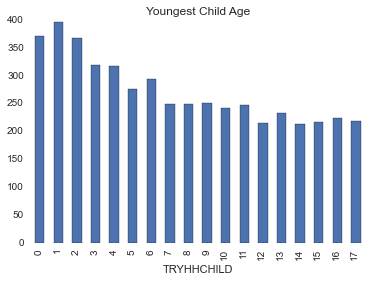

In [37]:
q = summary
q.groupby('TRYHHCHILD').size()[1:].plot(kind='bar',title='Youngest Child Age')

#####Youngest child ranges from 0 to 17, with > 200 observations at each age, so we should have enough data for some meaningful analysis

###How much more sleep do non-parents get than parents of newborns?

In [38]:
adults = summary[summary.TEAGE > 17]
newborn_parents = adults[adults.TRYHHCHILD == 0].set_index('tucaseid')
non_parents = adults[adults.TRYHHCHILD == -1].set_index('tucaseid')
cols = [col for col in newborn_parents]

In [39]:
nonp_sleeping = atus.average_minutes(non_parents, '010101')
newp_sleeping = atus.average_minutes(newborn_parents, '010101')
nonp_sleeping/newp_sleeping # Ratio of sleep for non-parents vs parents of newborns
# This does not make sense! I would expect a much higher ratio.

1.0019294840010831

####Answer: According to the data, it's very close between the two groups

###But what about mother versus fathers of newborns?
Simplifying assumption: An adult living with a child less than 1 year old is assumed to be the parent

In [40]:
n = newborn_parents
dads = n[n.TESEX==1]
moms = n[n.TESEX==2]
all_sleep = atus.average_minutes2(dads, '0101') / atus.average_minutes2(moms, '0101')
full_sleep = atus.average_minutes2(dads, '010101') / atus.average_minutes2(moms, '010101')
sleepless = atus.average_minutes2(dads, '010102') / atus.average_minutes2(moms, '010102')
dad_sleepless = atus.average_minutes2(dads, '010102')
all_sleep, full_sleep, sleepless, dad_sleepless

/Users/jdw/ironyard/sandbox/W4D4/atus-analysis/atus.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['minutes'] = activity_sums


(0.91401130648683016,
 0.90939161311771977,
 2.8667183758724453,
 3.6679397871643138)

####This shows that fathers of newborns (< 1 year old) get an average of ~91% the sleep that mothers get, and have spend nearly 3 times as much time experiencing sleeplessness.
On further inspection, however, the average sleeplessness figure is only 3.7 minutes, so the difference in sleeplessness is not likely significant.

###How does time spent on lawn/garden/houseplants vary with age of youngest child?



/Users/jdw/ironyard/sandbox/W4D4/atus-analysis/atus.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[str(col+'_wgt')] = data.TUFINLWGT * data[col]


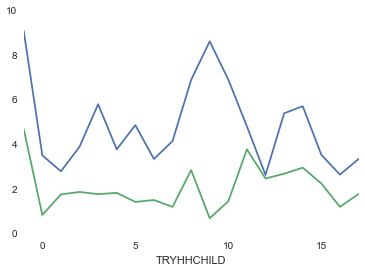

In [119]:
#q.groupby('TRYHHCHILD').size()[1:].plot(kind='bar',title='Youngest Child Age')
atus.search_codes('lawn') # We want t020501
q['t020501_wtd']=atus.weighted_col(q,'t020501')
weights = q.groupby('TRYHHCHILD').TUFINLWGT.sum()
q2 = q.groupby(['TRYHHCHILD', 'TESEX']).t020501_wtd.sum().unstack().rename(columns={1:"Male", 2:"Female"})
qm = q2['Male'] / weights
qf = q2['Female'] / weights #.plot(kind='bar')
qm.plot()
qf.plot()
#q.t020501_wtd.max()  == 14042618631.02562 !!

####Conclusion: It would appear that new babies have a deleterious effect on the time spent tending the lawn, garden, and houseplants.  Adults without children, appear to consistently spend more time caring for plants than parents do.

##Outlier Studies -- What is the maximum time anyone spends on each activity?
###And what else do these individuals do in the same day?

In [41]:
s = summary.set_index('tucaseid')
xp = atus.one_track_minds(s)
# [user_report(s,i[0]) for i in xp.iloc[0:50].iterrows()]

/Users/jdw/ironyard/sandbox/W4D4/atus-analysis/.direnv/python-3.4.3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


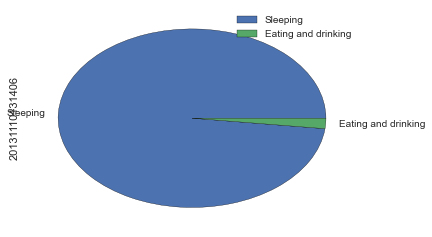

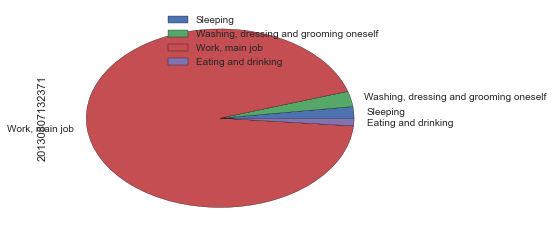

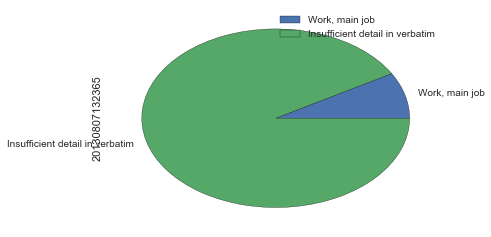

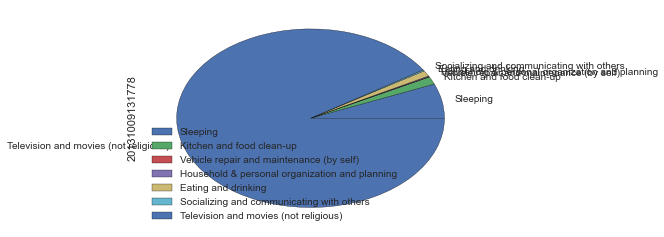

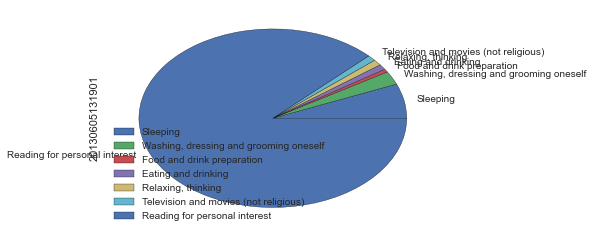

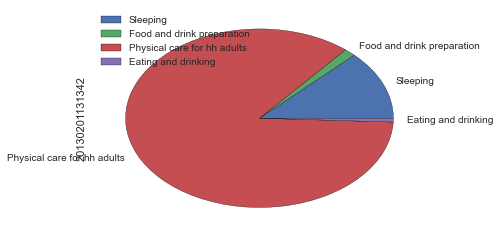

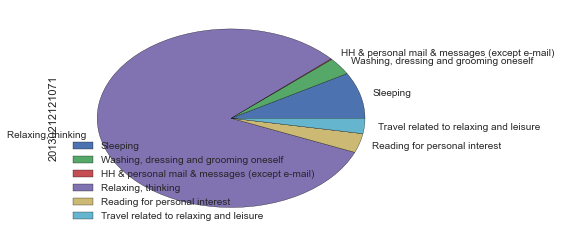

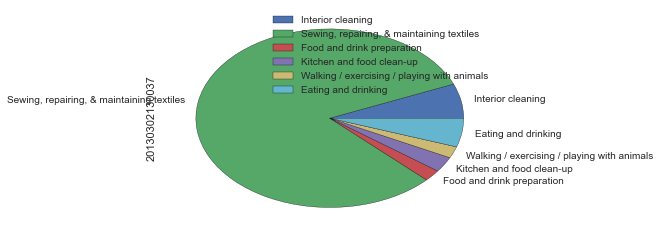

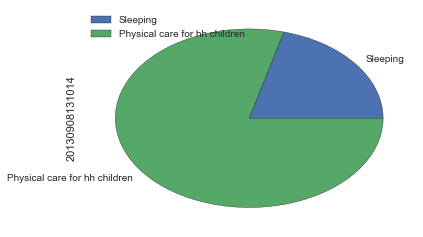

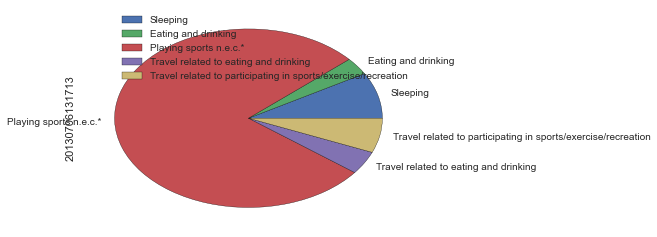

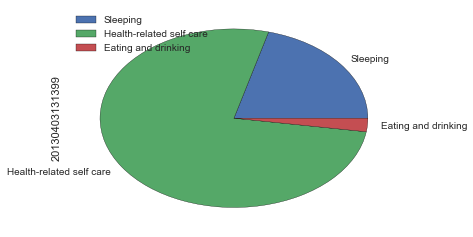

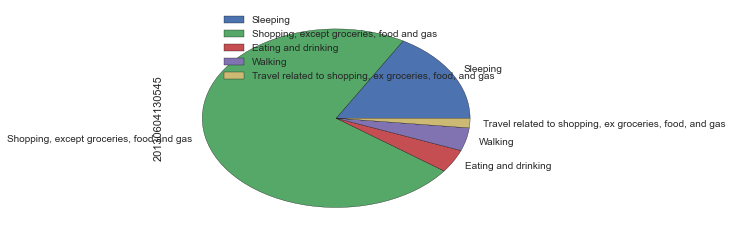

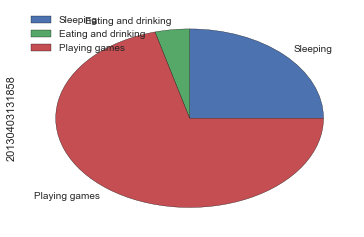

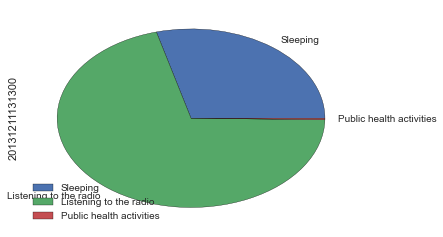

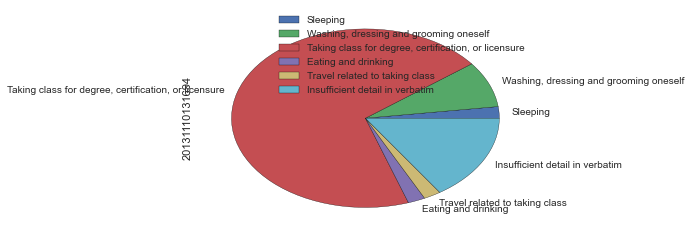

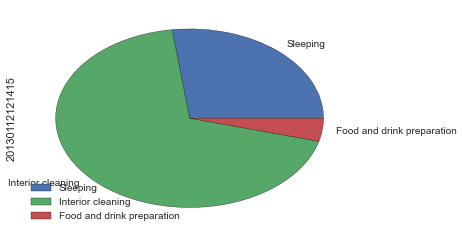

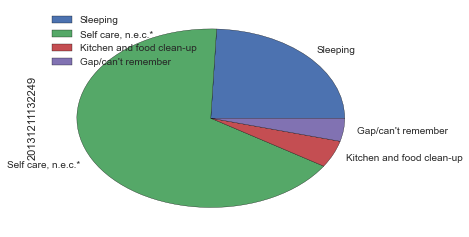

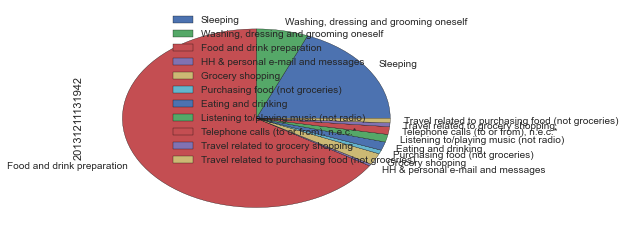

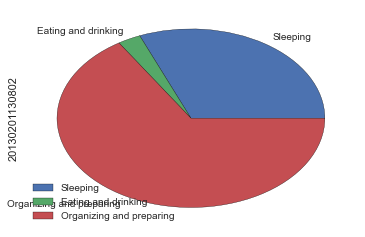

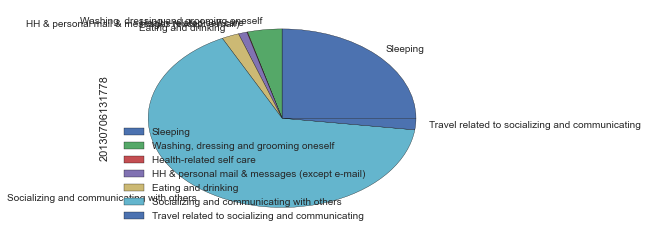

In [42]:
for user in [user for user in xp.index][:20]:
    hours, bio = atus.user_report(s, user)
    hours.plot(kind='pie', subplots=True)
plt.figure(figsize=(20,10))
# plt.plot?

In [122]:
from IPython.display import display
pd.options.display.max_columns = 30 #20 by default

reports = [atus.user_report(s,i[0]) for i in xp.iloc[0:].iterrows()]
xps = pd.DataFrame()
cc = 1
for i, val in enumerate(reports):
    bb = reports[i][1].stack().unstack(0)
    bb.index.names=['tucaseid']
    cc = pd.merge(xp, bb, left_index=True, right_index=True)
    xps = xps.append(cc)
xps


,hours,activity,description,atus_final_weight,youngest_child_age,age_edited,gender,education_level,race,is_hispanic,metropolitan_status,employment_status,has_multiple_jobs,work_status,is_student,school_level,partner_present,partner_employed,weekly_earnings_main,household_children,partner_work_status,weekly_hours_worked,date,is_holiday,eldercare_minutes,childcare_minutes
tucaseid,,,,,,,,,,,,,,,,,,,,,,,,,,
20131110131406,23.550000,t010101,Sleeping,1899058.155655,-1,52,2,39,2,2,1,1,2,1,-1,-1,3,-1,48000,0,-1,40,7,0,27,0
20130807132371,22.500000,t050101,"Work, main job",3107214.726310,9,47,1,43,1,1,1,1,2,1,2,-1,1,1,192307,2,1,45,1,0,-1,0
20130807132365,22.000000,t500101,Insufficient detail in verbatim,3345022.104425,2,32,1,40,1,2,1,1,2,1,2,-1,1,2,288461,2,-1,99,1,0,-1,0
20131009131778,21.816667,t120303,Television and movies (not religious),3495526.270281,-1,63,1,38,2,2,1,4,-1,-1,-1,-1,3,-1,-1,0,-1,-1,4,0,-1,0
20130605131901,21.050000,t120312,Reading for personal interest,2218752.415573,-1,85,1,40,1,2,1,5,-1,-1,-1,-1,3,-1,-1,0,-1,-1,7,0,-1,0
20130201131342,20.500000,t030401,Physical care for hh adults,4884344.681430,-1,58,2,43,1,2,1,2,2,2,-1,-1,3,-1,76923,0,-1,12,1,0,-1,0
20130212121071,19.716667,t120301,"Relaxing, thinking",6002226.550923,-1,80,1,38,1,2,1,5,-1,-1,-1,-1,3,-1,-1,0,-1,-1,3,0,-1,0
20130302130037,19.583333,t020103,"Sewing, repairing, & maintaining textiles",1940694.543983,-1,65,2,36,1,2,2,1,2,2,-1,-1,3,-1,10000,0,-1,10,1,1,-1,0
20130908131014,19.000000,t030101,Physical care for hh children,7872288.902837,0,30,2,43,1,2,1,1,2,2,2,-1,1,1,30000,1,1,15,5,0,-1,0


In [50]:
# Let's investigate the person who spent nearly 16 hours "Organizing and Preparing"
r = respondents.set_index('TUCASEID')
display(r.loc[20130201130802])
a = activities.set_index('TUCASEID')
a.loc[20130201130802]

TULINENO         1
TUYEAR        2013
TUMONTH          2
TEABSRSN        -1
TEERN           -1
TEERNH1O        -1
TEERNH2         -1
TEERNHRO        -1
TEERNHRY        -1
TEERNPER        -1
TEERNRT         -1
TEERNUOT        -1
TEERNWKP        -1
TEHRFTPT        -1
TEHRUSL1        -1
TEHRUSL2        -1
TEHRUSLT        -1
TEIO1COW        -1
TEIO1ICD        -1
TEIO1OCD        -1
TELAYAVL        -1
TELAYLK         -1
TELFS            5
TELKAVL         -1
TELKM1          -1
TEMJOT          -1
TERET1           2
TESCHENR        -1
TESCHFT         -1
TESCHLVL        -1
              ... 
TXERNRT         -1
TXERNUOT        -1
TXERNWKP        -1
TXHRFTPT         1
TXHRUSL1        -1
TXHRUSL2        -1
TXHRUSLT        -1
TXIO1COW        -1
TXIO1ICD        -1
TXIO1OCD        -1
TXLAYAVL        -1
TXLAYLK         -1
TXLFS            0
TXLKAVL         -1
TXLKM1          -1
TXMJOT          -1
TXRET1           0
TXSCHENR        -1
TXSCHFT         -1
TXSCHLVL        -1
TXSPEMPNOT      -1
TXSPUHRS    

,TUACTIVITY_N,TEWHERE,TRTCCTOT_LN,TRTCC_LN,TRTCOC_LN,TRTEC_LN,TRTHH_LN,TRTNOHH_LN,TRTOHH_LN,TRTONHH_LN,TRTO_LN,TRWBELIG,TUACTDUR,TUACTDUR24,TUCC5,TUCC5B,TUCC7,TUCC8,TUCUMDUR,TUCUMDUR24,TUDURSTOP,TUEC24,TUSTARTTIM,TUSTOPTIME,TUTIER1CODE,TUTIER2CODE,TUTIER3CODE,TRCODE,TRTIER2,TXWHERE
TUCASEID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20130201130802,1,-1,0,-1,0,-1,-1,-1,-1,-1,-1,0,90,90,0,0,0,97,90,90,2,-1,04:00:00,05:30:00,1,1,1,10101,101,0
20130201130802,2,1,0,-1,0,-1,-1,-1,-1,-1,-1,1,390,390,0,0,0,0,480,480,2,-1,05:30:00,12:00:00,15,1,2,150102,1501,0
20130201130802,3,1,0,-1,0,-1,-1,-1,-1,-1,-1,1,20,20,0,0,0,0,500,500,1,-1,12:00:00,12:20:00,11,1,1,110101,1101,0
20130201130802,4,1,0,-1,0,-1,-1,-1,-1,-1,-1,1,370,370,0,0,0,0,870,870,2,-1,12:20:00,18:30:00,15,1,2,150102,1501,0
20130201130802,5,1,0,-1,0,-1,-1,-1,-1,-1,-1,1,20,20,0,0,0,0,890,890,1,-1,18:30:00,18:50:00,11,1,1,110101,1101,0
20130201130802,6,1,0,-1,0,-1,-1,-1,-1,-1,-1,1,190,190,0,0,0,0,1080,1080,2,-1,18:50:00,22:00:00,15,1,2,150102,1501,0
20130201130802,7,-1,0,-1,0,-1,-1,-1,-1,-1,-1,0,450,360,0,0,0,0,1530,1440,2,-1,22:00:00,05:30:00,1,1,1,10101,101,0


###Who was the most unwilling participant and what did he/she report doing that day?

In [123]:
xps[xps.activity=='t500105']

,hours,activity,description,atus_final_weight,youngest_child_age,age_edited,gender,education_level,race,is_hispanic,metropolitan_status,employment_status,has_multiple_jobs,work_status,is_student,school_level,partner_present,partner_employed,weekly_earnings_main,household_children,partner_work_status,weekly_hours_worked,date,is_holiday,eldercare_minutes,childcare_minutes
tucaseid,,,,,,,,,,,,,,,,,,,,,,,,,,
20130807132318,2.75,t500105,"Respondent refused to provide information/""non...",10910565.622416,2,29,1,39,1,2,2,1,2,1,2,-1,1,1,53846,1,2,40,3,0,-1,465


In [128]:
hours, bio = atus.user_report(s, 20130807132318)
hours

,20130807132318
Sleeping,6.500000
"Work, main job",8.000000
"Shopping, except groceries, food and gas",1.500000
Eating and drinking,0.666667
"Relaxing, thinking",2.916667
Travel related to working,1.083333
"Travel related to shopping, ex groceries, food, and gas",0.583333
"Respondent refused to provide information/""none of your business""",2.750000


###Who was the most sleepless, and how did he/she spend their day?

In [129]:
xps[xps.activity=='t010102']

,hours,activity,description,atus_final_weight,youngest_child_age,age_edited,gender,education_level,race,is_hispanic,metropolitan_status,employment_status,has_multiple_jobs,work_status,is_student,school_level,partner_present,partner_employed,weekly_earnings_main,household_children,partner_work_status,weekly_hours_worked,date,is_holiday,eldercare_minutes,childcare_minutes
tucaseid,,,,,,,,,,,,,,,,,,,,,,,,,,
20131109132113,9.75,t010102,Sleeplessness,14290010.243587,3,39,1,39,1,2,1,5,-1,-1,2,-1,1,1,-1,2,1,-1,2,0,-1,375


In [130]:
hours, bio = atus.user_report(s, 20131109132113)
hours


,20131109132113
Sleeping,1.000000
Sleeplessness,9.750000
"Washing, dressing and grooming oneself",0.833333
Looking after hh children (as a primary activity),0.166667
"Shopping, except groceries, food and gas",0.250000
Eating and drinking,2.000000
Socializing and communicating with others,1.750000
"Relaxing, thinking",4.500000
Television and movies (not religious),2.250000
"Travel related to shopping, ex groceries, food, and gas",0.500000


###Just for fun: ATUS Mad Libs:

In [45]:
import mad_lib  # Generates a few semi-realistic sounding sentences using a the ATUS activity descriptions

In [49]:
mad_lib.mad_lib()

Sharona did a bit of vehicle & appliance maintenance/repair assistance for nonhh adults at work last night.
It was all fun and games until Jill randomly decided to start doing research/homework n.e.c.* all the time back when it meant something.
Jack ultimately decided that using cardiovascular equipment just wasn't the same as it used to be in his/her prime.


##Further Exploration

###Possible Questions:
- [What are the most extreme uses of the hours in a day?](#Outlier-Studies----What-is-the-maximum-time-anyone-spends-on-each-activity?)
- [Newborn parent sleep vs non-parents](#How-much-more-sleep-do-non-parents-get-than-parents-of-newborns?)
- [Newborn parent sleep - dads vs moms](#But-what-about-mother-versus-fathers-of-newborns?)
- [Amount of lawn work vs age of youngest child](#How-does-time-spent-on-lawn/garden/houseplants-vary-with-age-of-youngest-child?)
- Amount of alone time vs age of youngest child TRTALONE
- What are people doing at this moment in time?
- [What did people who responded "none of your business" 500105 do otherwise?](#Who-was-the-most-unwilling-participant-and-what-did-he/she-report-doing-that-day?)
- Show a random correlation
- [What do sleepless people do?](#Who-was-the-most-sleepless,-and-how-did-he/she-spend-their-day?)
- OTPYG, by the numbers
- Rodeo vs ???
- Organizing and Preparing vs ???
- What do people do on holiday vs day off vs day of work? Weekend vs weekday?
- WB Activity file -- WUHAPPY

###Possible groupings:
- Adults with and without children
- Age of youngest child (0-5, 6-11, 12-17)
- Age <25, <40, <65, >65
- Male/Female

###Other variables/files of interest:
- Actual activities file

###Discussion Points:
- [Generating data dictionary from pdf](#See-parse_activities.py-for-the-code-to-convert-a-flat-list-of-codes-into-a-hierarchical-structure)
- [mad_lib](#Just-for-fun:-ATUS-Mad-Libs:)
- User report (building off of mad_lib)

###Other:
- Critical Functions:
    - atus.dictionaries in pa
    - atus.search_codes()
    - atus.pick_codes()
    - atus.user_report()
- Test suite

- Compare different populations (people with children and people without, people of differing age groups, men and women, or other groupings)
Answer macro-level questions and micro-level questions (for example, the amount of leisure for the macro-level, the types of things people do for leisure for the micro-level)
Your final analysis should be in the form of an IPython Notebook with both narrative analysis and supporting charts. Your supporting code should be in normal Python files.


#Table of Contents:
* [Back to Top](#ATUS-Analysis)
* [Table of Contents](#Table-of-Contents:)
* [Relevant Links](#Relevant-links:)
* [Groups](#Define-population-groups-for-analysis)
* [Joining Files](#Joining-files)
* [Correlation Matrix](#Correlation-matrix)
* [Verifying BLS Statistics](#Verifying-summary-statistics-from-BLS-website:)
* [Further Analyses](#Now-for-some-basic-analyses-using-the-summary-data)
    * [One-track-minds](#Quick-Analysis----What-is-the-maximum-time-anyone-spends-on-each-category?)
* [Further Exploration](#Further-Exploration)
* [End](#End)

##End